# SYSID - Atividade 04

Aluno: Pedro Henrique Cardoso Paulo

Professor: Helon Ayala

## Objetivo

Nessa atividade seguiremos estudando o dataset utilizado na <a href="../Atividade03/Atividade03.ipynb">Atividade 3</a>. Dessa vez, compararemos o uso do método de Batch Least Squares com o método Recursive Least Squares, tetando entender qual deles gera o melhor resultado. A ordem do modelo será tal como estimada na <a href="../Atividade03/Atividade03.ipynb">Atividade 3</a>, ou seja, usaremos `na  = 4` e `nb = 6`.

## Passo 0 - Inicializando o Nb

### 0.1 - Limpando memória, prompt e inicializando random seed

In [50]:
% MEC 2015 System identification
% Prof Helon Ayala

clc
clear
close all
%rng(1) % permite reproducibilidade (indisponivel no octave 6 que usei)
%random_seed = 1;
%randn("seed", random_seed);

### 0.2 - Importando pacotes

Parra esse caso, não serão necessários pacotes.

In [51]:
%pkg load control %pkg control: funcoes de transferencia e c2d

## Passo 1 - Carregando os dados

Para esse caso, serão usados dados reais de um braço robótico. Os dados podem ser baixados no seguinte endereço:

<a>https://ftp.esat.kuleuven.be/pub/SISTA/data/mechanical/robot_arm.dat.gz</a>

Os dados foram baixados compactados e extraídos, resultando em um arquivo de texto.

### 1.1 - Importando os dados

In [52]:
DATA = dlmread('../data/robot_arm.dat');
Y = DATA(:,1);
U = DATA(:,2);

% vetor tempo discreto
t = (1:length(Y));

Espera-se que um ajuste por mínimos quadrados retorne um vetor $\theta$ similar ao descrito.

### 1.2 - Visualizando os dados

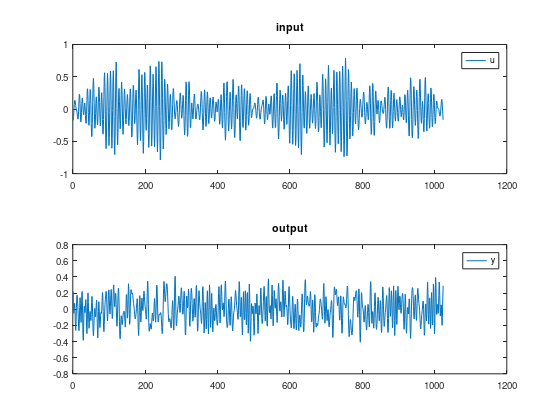

In [53]:
figure
subplot(2,1,1)
plot(t,U)
title('input')
legend('u');
subplot(2,1,2)
plot(t,Y)
title('output')
legend('y');

### 1.3 - Dividindo dados em treino e validação

Para esse exercício, vamos propor uma divisão do trend em 50% de dados para o treino e 50% para a validação. Essa divisão será usada para fins de ajuste do modelo, de modo que os plots e comparações considerarão o conjunto total dos dados.

In [54]:
train_fraction = 0.5; % Fracao de valores para treino
n = length(t);

n_TRA = round(n*train_fraction) % Numero de elementos para treino
n_VAL = n - n_TRA

tTRA = t(1:n_TRA);
tVAL = t(n_TRA+1:end);

YTRA = Y(1:n_TRA);
YVAL = Y(n_TRA+1:end);

UTRA = U(1:n_TRA);
UVAL = U(n_TRA+1:end);


n_TRA = 512
n_VAL = 512


## Parte 2 - Realizando ajuste por batelada

Nessa primeira etapa vamos replicar o melhor ajuste anteriormente feito na <a href="../Atividade03/Atividade03.ipynb">Atividade 3</a>. O ajuste será feito por batelada e as métricas de erro, comparadas.

### 2.0 - Definindo parâmetros globais do ajuste (`na` e `nb`)

In [55]:
na = 4;
nb = 6;
p = max([na nb])+1;

### 2.1 - Calculando matriz de regressão para ambos os trends

In [56]:
[PhiAJUSTE, YAJUSTE]    = matReg (YTRA, UTRA, na, nb);
[Phi, YCOMP] = matReg (Y, U, na, nb);

### 2.2 - Estimando os parâmetros

In [57]:
% estimate parameters:
th_hat_BLS = (PhiAJUSTE'*PhiAJUSTE)^(-1)*PhiAJUSTE'*YAJUSTE % batch least squares

th_hat_BLS =

   -2.7423
    3.5369
   -2.6373
    0.9107
   -3.9514
   16.1173
  -28.2874
   26.8301
  -13.6117
    2.9190



### 2.3 - Realizando a simulação

In [58]:
% one step ahead prediction
yhat_COMP_OSA = simulate_OSA (Phi, th_hat_BLS);

yhat_COMP_FS = simulate_FS (Phi(1,:), th_hat_BLS, U, na, nb);


### 2.4 - Comparando resultados

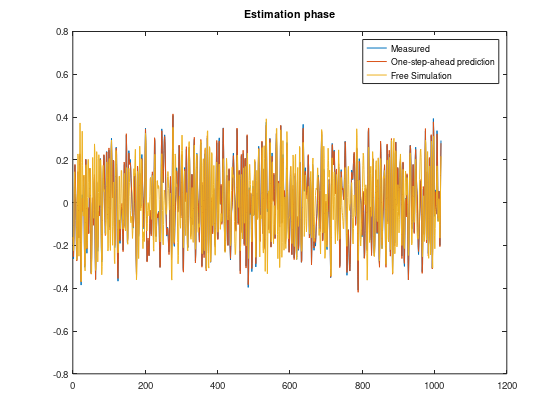

In [59]:
% plot predictions
figure
plot([YCOMP yhat_COMP_OSA yhat_COMP_FS])
title('Estimation phase')
legend('Measured','One-step-ahead prediction', 'Free Simulation')

### 2.6 - Extraindo as métricas $R^2$

A métrica $R^2$ é definida por meio da seguinte expressão:

$
R^2 = 1 - \frac{\sum^N_{t=1} [\xi(t)]^2}{\sum^N_{t=1} [y(t)-\bar{y}]^2}
$

Essa métrica é uma medida de correlação entre os dados estimados e os dados reais, em que o quãao mais próximo $R^2$ é de 1, melhor é o ajuste. Calculando a métrica:

In [60]:
R2_COMP_OSA = mult_corr(YCOMP,yhat_COMP_OSA);
R2_COMP_FS  = mult_corr(YCOMP,yhat_COMP_FS);

fprintf('R2 obtained (1 is perfect) \n')
fprintf('R2_COMP_OSA \t R2_COMP_FS\n')
fprintf('%0.4f \t\t %0.4f\n',R2_COMP_OSA,R2_COMP_FS)

R2 obtained (1 is perfect) 
R2_COMP_OSA 	 R2_COMP_FS
0.9968 		 0.4623


### 2.7 - Plotando testes estatísticos

Os testes estatísticos são outra forma de avaliar a qualidade do ajuste. O principal teste estatístico levado em conta é a autocorrelação, definida como:

$
\phi_{ab}(\tau) = \frac{\sum^N_{t=1} [a(t)-\bar{a}][b(t+\tau)-\bar{b}]}{\left[\left[\sum^N_{t=1} [a(t)-\bar{a}]^2\right]\left[\sum^N_{t=1} [b(t)-\bar{b}]^2\right]\right]^{\frac{1}{2}}}
$

Para um modelo linear simples, como o que esperamos, os principais testes estatísticos relevantes são:

$
\begin{cases}
\phi_{\xi\xi} = \delta(\tau), \\
\phi_{u\xi} = 0
\end{cases}
$

Caso ambos os critérios sejam atendidos para todo $\tau$, podemos provar que o erro é aleatório e que não devemos ter ganho aumentando a ordem do modelo. Esses testes correspondem aos dois primeiros gráficos da função a seguir:

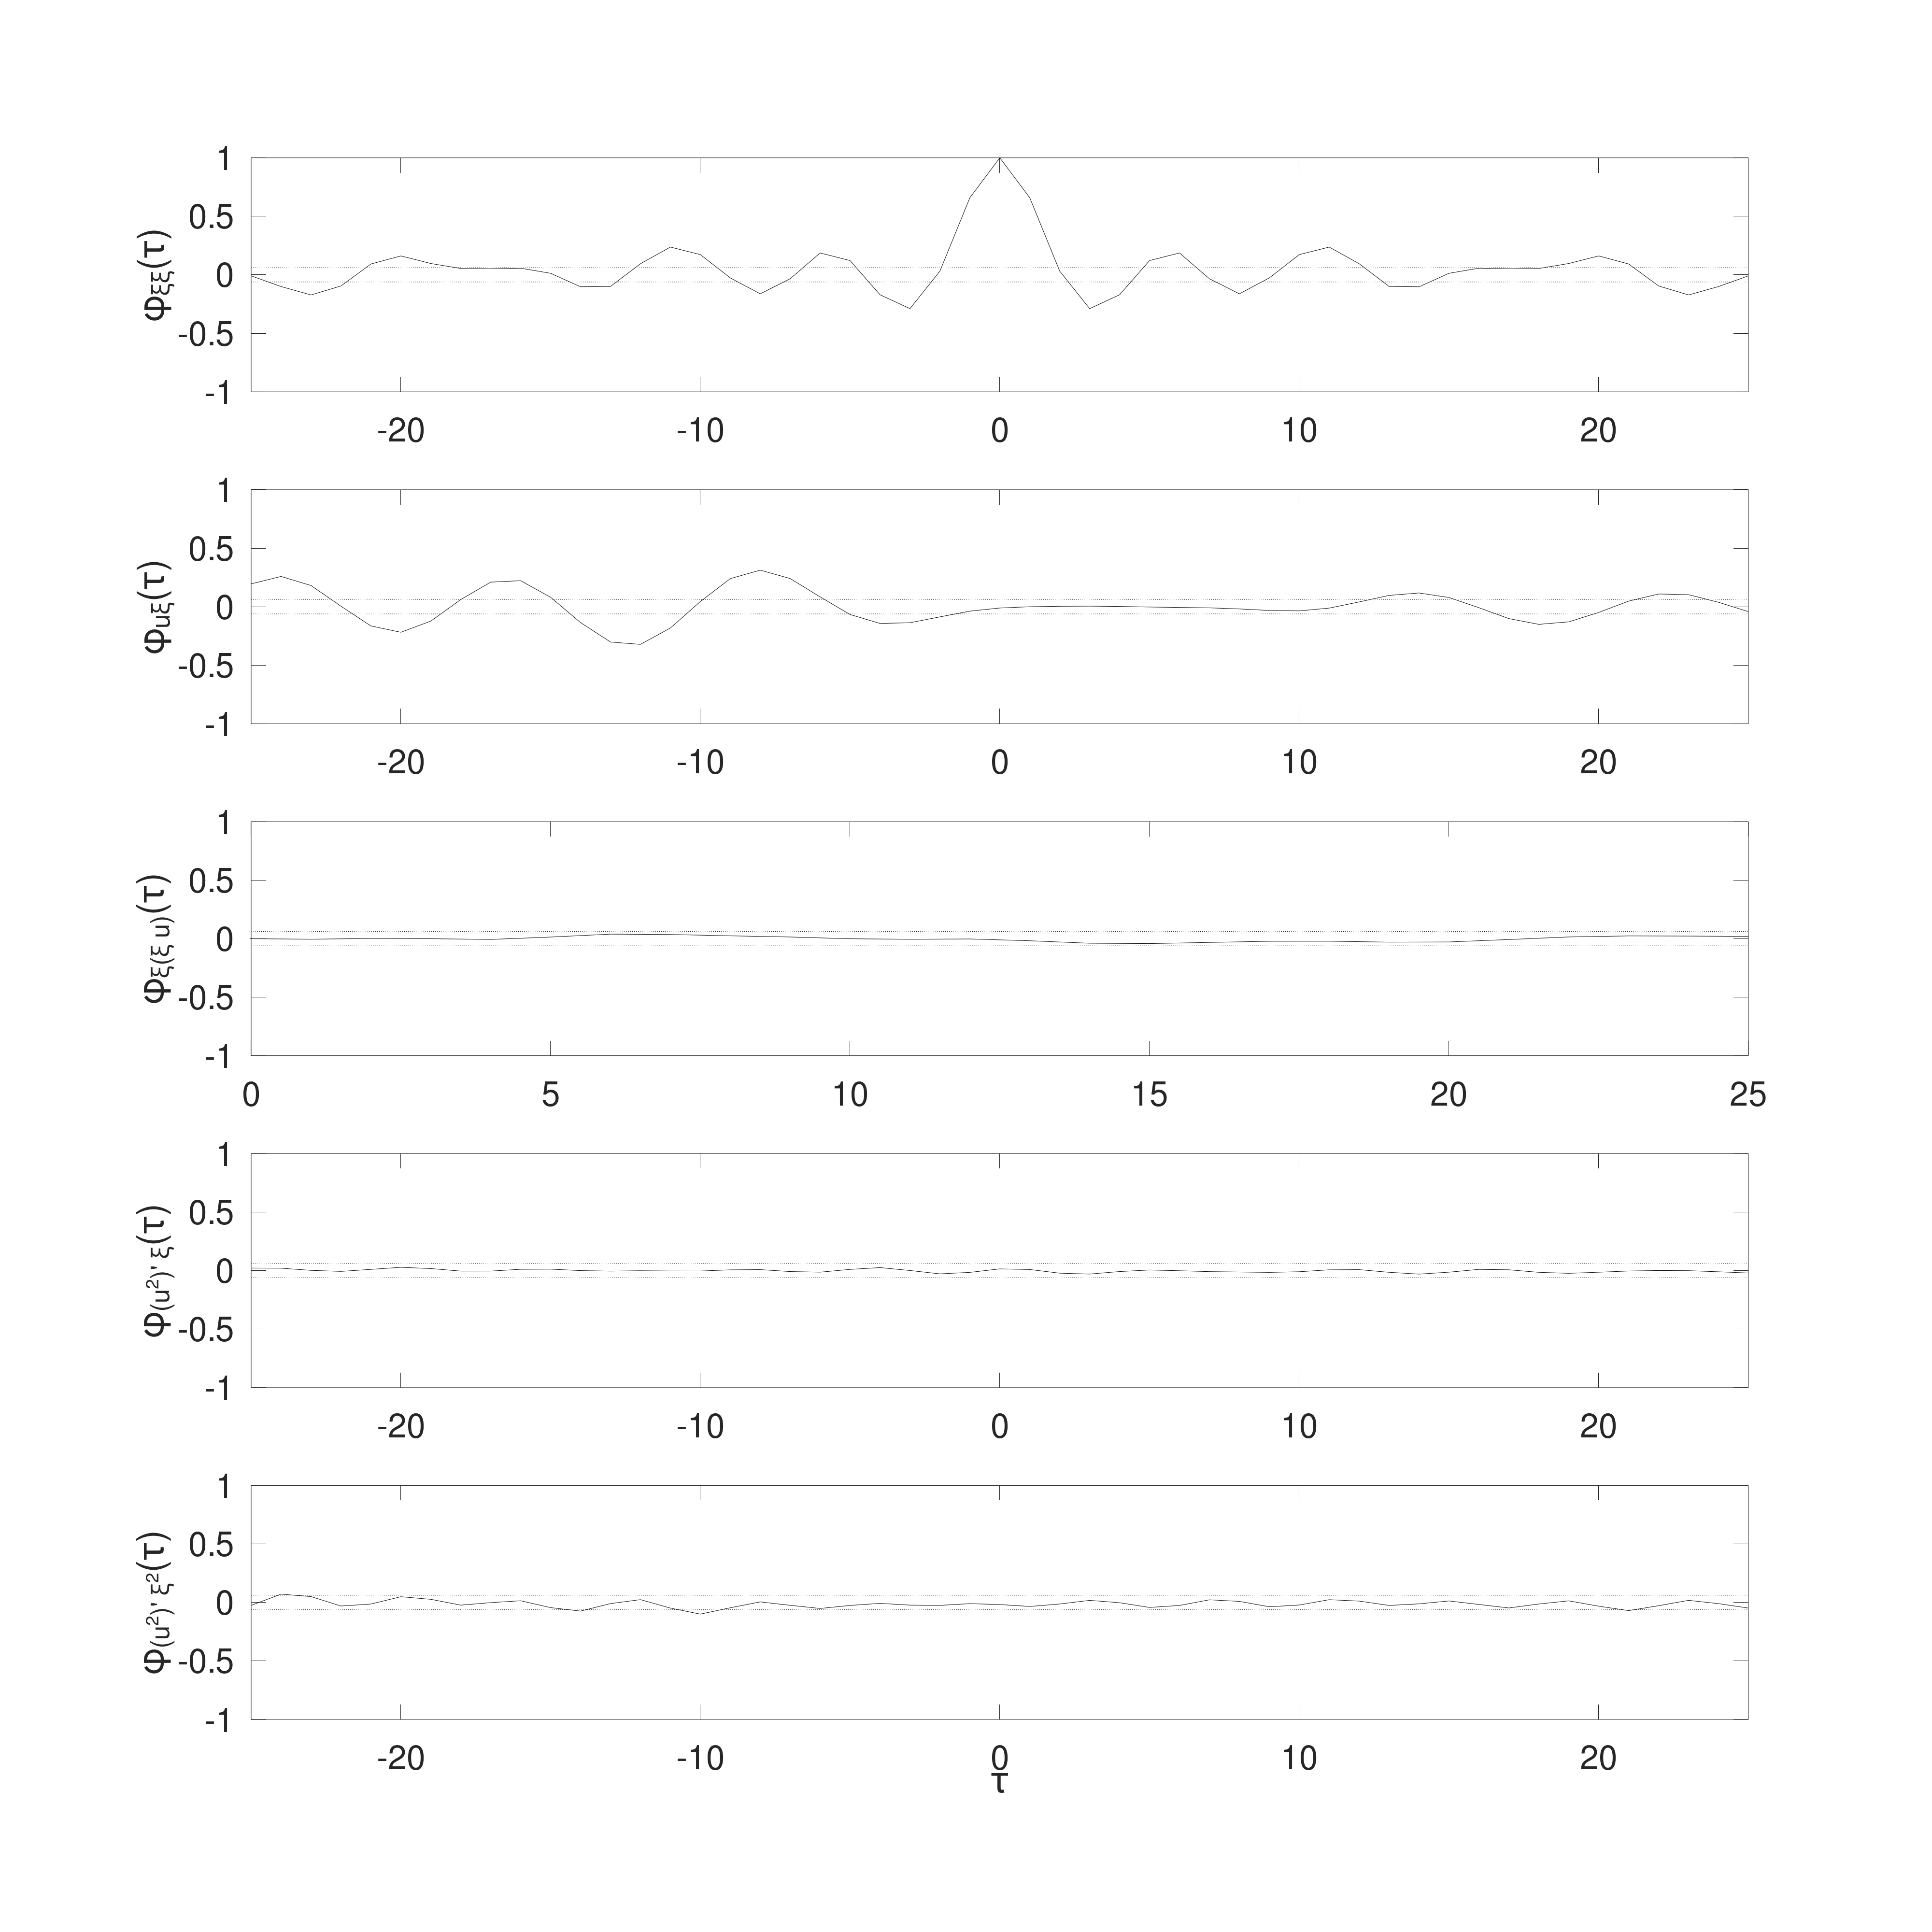

In [61]:
plot_xcorrel(YCOMP-yhat_COMP_OSA,U(p:end))

## Parte 3 - Realizando ajuste recursivo

Para essa etapa, vamos realizar o ajuste recursivo para a série inteira de dados e avaliar se há ganho com relação ao método anterior.

### 3.1 - Simulando com o mínimos quadrados recursivo

In [62]:
[yhat_COMP_RLS1, th_hat_RLS1] = RLS(Y, U, na, nb, 1, 0.98);
th_hat_RLS1(:,end)

ans =

   -2.6794
    3.4331
   -2.5173
    0.8415
   -2.3740
    9.3567
  -15.5660
   13.7538
   -6.2539
    1.0745



### 3.2 Comparando resultados

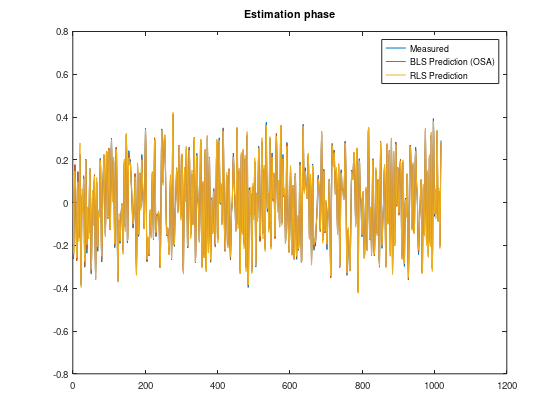

In [63]:
% plot predictions
figure
plot([YCOMP yhat_COMP_OSA yhat_COMP_RLS1(p:end)])
title('Estimation phase')
legend('Measured','BLS Prediction (OSA)', 'RLS Prediction')

### 3.3 - Comparando vetores $\theta$

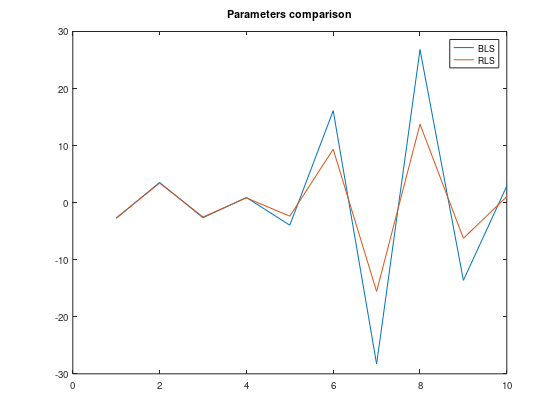

In [64]:
figure
plot([th_hat_BLS th_hat_RLS1(:,end)])
title('Parameters comparison')
legend('BLS','RLS')

### 3.4 - Analisando a convergência de $\theta$ com o tempo

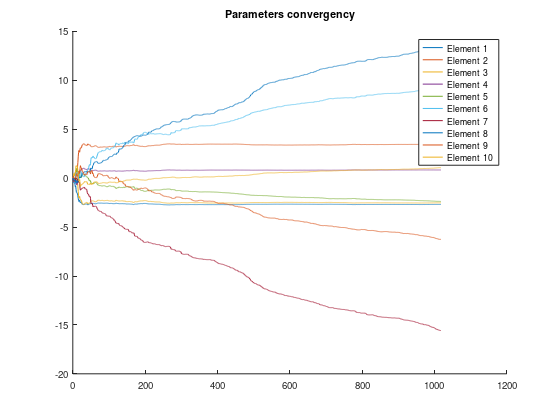

In [65]:
shp = size(th_hat_RLS1);
labels = [];
figure
hold on
title('Parameters convergency')
for i=1:shp(1)
    plot(th_hat_RLS1(i,:),"DisplayName",sprintf("%s %d %s","Element ",i))
endfor
legend


### 3.5 - Calculando $R^2$

In [66]:
R2_COMP = mult_corr(YCOMP,yhat_COMP_RLS1(p:end));

fprintf('R2 obtained (1 is perfect) \n')
fprintf('R2_COMP\n')
fprintf('%0.4f\n',R2_COMP)

R2 obtained (1 is perfect) 
R2_COMP
0.9898


### 3.6 - Plotando testes estatísticos

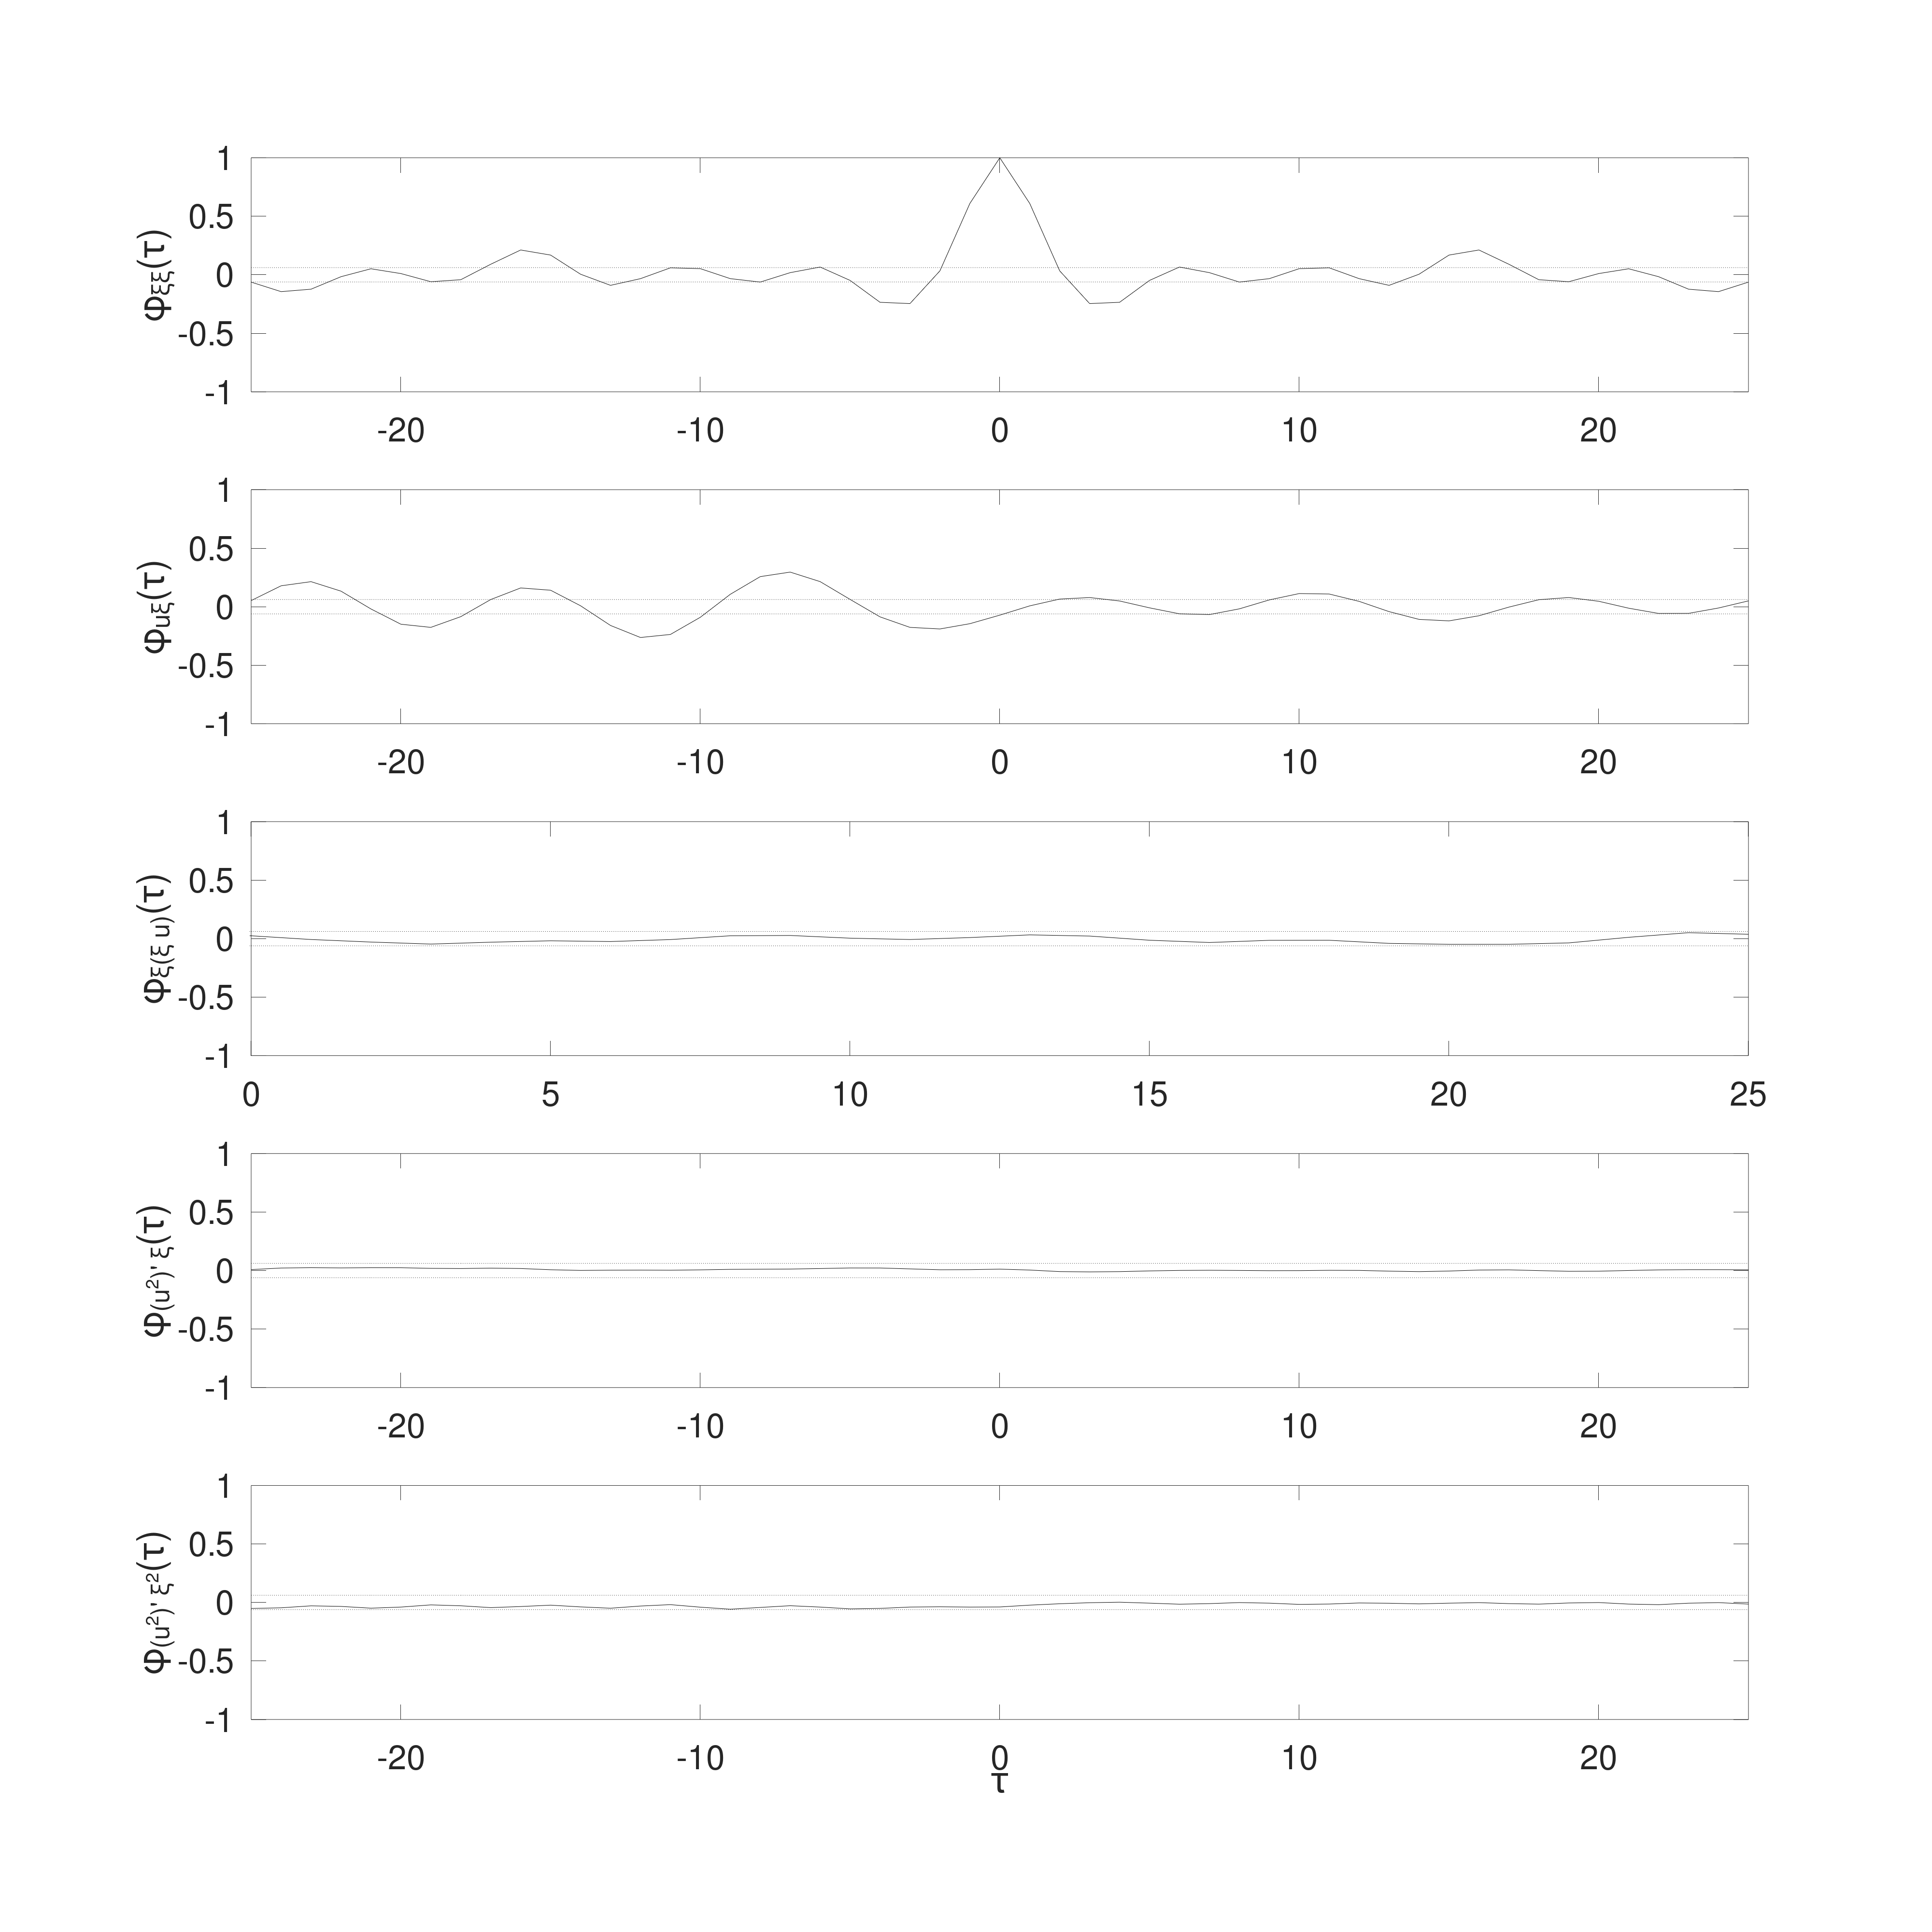

In [67]:
plot_xcorrel(YCOMP-yhat_COMP_RLS1(p:end),U(p:end))

### 3.7 - Conclusões da execução do RLS

Para o presente problema, não houve nenhum ganho na aplicação do RLS puro. O valor final de $R^2$ ficcou ligeiramente pior porém dentro de uma margem aceitável, o que leva a conclusão de que os resultados foram análogos.

## Parte 4 - Avaliando métodos para mais adaptabilidade no RLS

Nesta seção vamos testar a aplicação de métodos como random walk e forgetting factor para aproximar o reultado do RLS ao do BLS e reduzir o $R^2$. Fixaremos, a priori, o forgettting factor em 0,98, não buscando um ótimo pra esse parâmetro.

### 4.1 - Calculando as predições

In [68]:
[yhat_COMP_RLS2, th_hat_RLS2] = RLS(Y, U, na, nb, 2, 0.98); %random walk
[yhat_COMP_RLS3, th_hat_RLS3] = RLS(Y, U, na, nb, 3, 0.98); %forgeetting factor
[th_hat_BLS th_hat_RLS1(:,end) th_hat_RLS2(:,end) th_hat_RLS3(:,end)]

ans =

  -2.7423e+00  -2.6794e+00  -1.2169e+00  -2.6989e+00
   3.5369e+00   3.4331e+00   9.7480e-01   3.4346e+00
  -2.6373e+00  -2.5173e+00  -1.4350e-01  -2.5327e+00
   9.1073e-01   8.4152e-01  -2.9911e-01   8.6316e-01
  -3.9514e+00  -2.3740e+00  -2.9655e-02  -3.7890e+00
   1.6117e+01   9.3567e+00   4.6382e-01   1.5357e+01
  -2.8287e+01  -1.5566e+01   2.4978e-01  -2.6793e+01
   2.6830e+01   1.3754e+01  -2.2941e-02   2.5281e+01
  -1.3612e+01  -6.2539e+00   1.1919e-01  -1.2740e+01
   2.9190e+00   1.0745e+00   6.1896e-01   2.7114e+00



### 4.2 - Comparando os resultados das predições

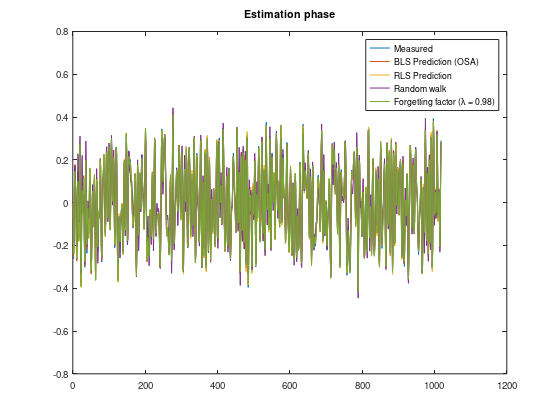

In [73]:
% plot predictions
figure
plot([YCOMP yhat_COMP_OSA yhat_COMP_RLS1(p:end) yhat_COMP_RLS2(p:end) yhat_COMP_RLS3(p:end)])
title('Estimation phase')
legend('Measured','BLS Prediction (OSA)', 'RLS Prediction', 'Random walk', 'Forgetting factor (\lambda = 0.98)')

### 4.3 - Comparando os vetores $\theta$

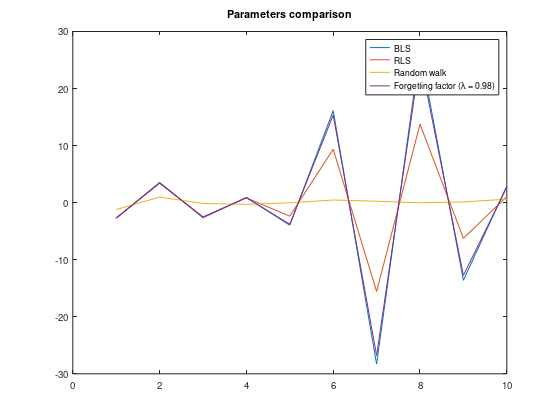

In [72]:
figure
plot([th_hat_BLS th_hat_RLS1(:,end) th_hat_RLS2(:,end) th_hat_RLS3(:,end)])
title('Parameters comparison')
legend('BLS','RLS', 'Random walk', 'Forgetting factor (\lambda = 0.98)')

### 4.4 - Comparando a convergência dos métodos

#### 4.4.1 - Random Walk

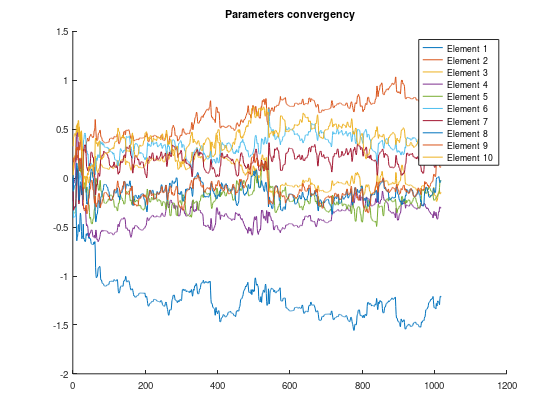

In [84]:
shp = size(th_hat_RLS2);
labels = [];
figure
hold on
title('Parameters convergency')
for i=1:shp(1)
    plot(th_hat_RLS2(i,:),"DisplayName",sprintf("%s %d %s","Element ",i))
endfor
legend

#### 4.4.2 - Forgetting Factor ($\lambda=0.98$)

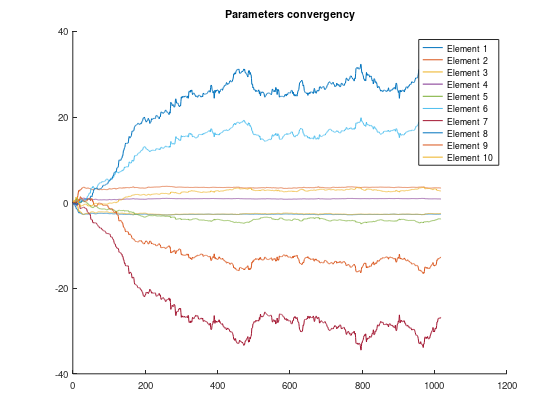

In [85]:
shp = size(th_hat_RLS3);
labels = [];
figure
hold on
title('Parameters convergency')
for i=1:shp(1)
    plot(th_hat_RLS3(i,:),"DisplayName",sprintf("%s %d %s","Element ",i))
endfor
legend

### 4.5 - Comparando o $R^2$

In [83]:
fprintf('R2 obtained (1 is perfect) \n')
fprintf('Method \t\t\t\t R2_COMP\n')
fprintf('%s \t\t\t\t %0.4f\n','BLS',mult_corr(YCOMP,yhat_COMP_OSA))
fprintf('%s \t\t\t\t %0.4f\n','RLS',mult_corr(YCOMP,yhat_COMP_RLS1(p:end)))
fprintf('%s \t\t\t %0.4f\n','Random Walk',mult_corr(YCOMP,yhat_COMP_RLS2(p:end)))
fprintf('%s \t\t %0.4f\n','Forgetting Factor',mult_corr(YCOMP,yhat_COMP_RLS3(p:end)))

R2 obtained (1 is perfect) 
Method 				 R2_COMP
BLS 				 0.9968
RLS 				 0.9898
Random Walk 			 0.9407
Forgetting Factor 		 0.9932


# Parte 5 - Conclusões

* No quesito $R^2$ da predição (Usando OSA como benchmark pro batch) os melhores métodos foram BLS e o Forgetting Factor
* Embora o Forgetting Factor tenha ajudado a uma convergência mais rápida do modelo, não parece haver mudança da física do problema ao longo do tempo, de modo que o modelo parece ser adequadamente representado por um sistema linear de coeficientes constantes
* O Random Walk levaou a pesos mais baixos e ao pior resultado de $R^2$. Valeaa pena tentar dar uma investigada nas causas, que podem ser:
    * A alta ordem do modelo está causando overfitting e o Random Walk está gerando um modelo mais extrapolável
    * Algum erro na implementação do Random Walk
    * Apenas, para esse caso, Random Walk se mostrou inadequado
* Não parece haver ganhos nos testes estatísticos trocando do BLS pro RLS, o que já era esperado